In [20]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from scipy.ndimage import gaussian_filter
import sys
from tqdm import tqdm
from functools import partial
import acd
from copy import deepcopy
sys.path.append('..')
sys.path.append('../..')
from transforms_torch import bandpass_filter
# plt.style.use('dark_background')
sys.path.append('../../dsets/mnist')
import dset
from model import Net, Net2c
from util import *
from numpy.fft import *
from torch import nn
from style import *
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)
import pickle as pkl
from torchvision import datasets, transforms
from sklearn.decomposition import NMF
import transform_wrappers
import visualize as viz
from model import Net, Net2c
torch.manual_seed(42)
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from acd_wooseok.acd.scores import cd
from acd_wooseok.acd.util import tiling_2d
from acd_wooseok.acd.scores import score_funcs
from torchvision import datasets, transforms

# Dataset

In [22]:
# load mnist dataloader
args = dset.get_args()
args.test_batch_size = 100
train_loader, test_loader = dset.load_data_with_indices(args.batch_size, args.test_batch_size, device)

# load the model
model = Net().to(device)
model.load_state_dict(torch.load('../../dsets/mnist/mnist.model', map_location=device))
model = model.eval()

# NMF in the hidden layers

In [62]:
# mods = list(model.modules())[1:8]
# X = np.empty((60000, 320))
# n = 0 # count total number of samples
# for i, (images, labels, _) in enumerate(train_loader):
#     batch_size = images.shape[0]
#     if device == 'cuda':
#         images = images.to(device)
#     X[n:n+batch_size] = evaluate_mods(images.to(device), mods).reshape(batch_size,-1).data.cpu().numpy()
#     n += batch_size

In [63]:
# test dataset
X_test = test_loader.dataset.data.numpy().astype(np.float32)
X_test = X_test.reshape(X_test.shape[0], -1)/255
Y_test = test_loader.dataset.targets.numpy()
print('X_test.shape', X_test.shape)

# run NMF
# nmf = NMF(n_components=30, max_iter=1000)
# nmf.fit(X)
# pkl.dump(nmf, open('./results/nmf_actmap_30.pkl', 'wb'))
nmf = pkl.load(open('./results/nmf_actmap_30.pkl', 'rb'))

# dicts & coeffs
D = nmf.components_
for i in range(nmf.n_components):
    D[i] = D[i]/np.linalg.norm(D[i])
print('D.shape', D.shape)
# viz.viz_basis(D.reshape(-1,28,28))

X_test.shape (10000, 784)
D.shape (30, 320)


# Relevant * NMF dictionaries

In [170]:
import cd_temp_wooseok 
results = {
    'pixel_scores': [], # (784, 20, 4, 4)
    'corr': [], # (784, 30)
    'feature_maps': [], # (1, 20, 4, 4)
    'dict_scores': [] # (30, 10)
}
for i in range(20):
    # transform layers
    norm = transform_wrappers.NormLayer(mu=0.1307, std=0.3081)
    norm_rel = transform_wrappers.NormLayer(mu=0.0, std=0.3081) 
    
    # test image
    x = X_test[i:i+1]
    im = norm(torch.Tensor(x)).reshape(28,28)
    im_rel = norm_rel(torch.Tensor(x)).reshape(28,28) 
    
    # pixel by cd-score and correlation
    tiles = torch.Tensor(tiling_2d.gen_tiles(im, fill=0, method='cd', sweep_dim=1))
    cd_scores_im = []
    rel_corr = []
    for j in range(28*28):  # can use tqdm here, need to use batches
        relevant = im_rel * tiles[j]
        cd_score = cd_temp_wooseok.cd(im, model, mask=None, model_type='mnist', device='cuda', transform=None,
                                 relevant=relevant)
        cd_scores_im.append(cd_score[0].data.cpu().numpy())
        rel_corr.append((cd_scores_im[-1].flatten() * D).sum(axis=1))
    cd_scores_im = np.squeeze(np.array(cd_scores_im))
    rel_corr = np.array(rel_corr)
    results['pixel_scores'].append(deepcopy(cd_scores_im))
    results['corr'].append(deepcopy(rel_corr))
    output = (cd_score[0] + cd_score[1]).data.cpu().numpy()
    results['feature_maps'].append(output)
    
    # dictionary by cd-score
    # transform layer
    transformer = transform_wrappers.lay_from_w(D).to(device)
    
    # weights
    x_t = nmf.transform(output.reshape(1,-1))
    x_t_tensor = torch.Tensor(x_t).to(device)
    output = torch.Tensor(output).to(device)
    
    # cd score over dictionary
    tiles = torch.Tensor(tiling_2d.gen_tiles(x_t, fill=0, method='cd', sweep_dim=1)).to(device)
    cd_scores_dict = []
    for j in range(nmf.n_components):
        relevant = transformer(tiles[j] * x_t_tensor).reshape(1,20,4,4)
        cd_score = cd_temp_wooseok.cd(output, model, mask=None, model_type='mnist', device='cuda', transform=None,
                                 relevant=relevant, ver=1) 
        cd_scores_dict.append(cd_score[0].data.cpu().numpy())
    cd_scores_dict = np.squeeze(np.array(cd_scores_dict))
    results['dict_scores'].append(deepcopy(cd_scores_dict))
    
    print('\riteration:', i, end='')

iteration: 19

# Visualize pixel-by-pixel correlation 

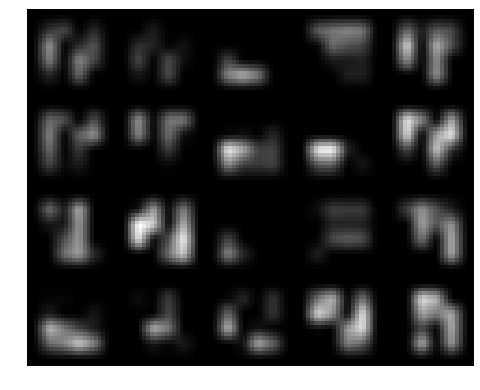

In [232]:
from skimage.transform import rescale
# plot of activation maps

plt.figure(figsize=(8,8))
n_row = 4
n_col = 5
p = 4 + 2
mosaic = np.zeros((p*n_row,p*n_col))
indx = 0
for i in range(n_row):
    for j in range(n_col):
        mosaic[i*p:(i+1)*p,j*p:(j+1)*p] = np.pad(results['feature_maps'][img_indx][0][indx],(1,1),mode='constant')
        indx += 1

plt.imshow(rescale(mosaic,4,mode='constant'), cmap='gray')
plt.axis('off')
plt.show()        

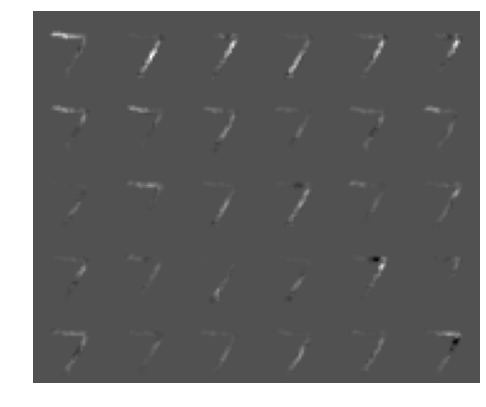

In [253]:
from skimage.transform import rescale
# plot of activation maps
img_indx = 0
label_indx = Y_test[img_indx]
ranking_indxs = np.argsort(results['dict_scores'][img_indx][:,label_indx])[::-1]

plt.figure(figsize=(8,8))
n_row = 5
n_col = 6
p = 28 + 2
mosaic = np.zeros((p*n_row,p*n_col))
n = 0
for i in range(n_row):
    for j in range(n_col):
        indx = ranking_indxs[n]
        mosaic[i*p:(i+1)*p,j*p:(j+1)*p] = np.pad(results['corr'][img_indx].T.reshape(-1,28,28)[indx],(1,1),mode='constant')
        n += 1

plt.imshow(rescale(mosaic,4,mode='constant'), cmap='gray')
plt.axis('off')
plt.show()        

# CD score for dictionary

In [211]:
labe_indx = 0
channel_indx = 0
dict_indx = 13
D_ = D.reshape(-1,20,4,4)

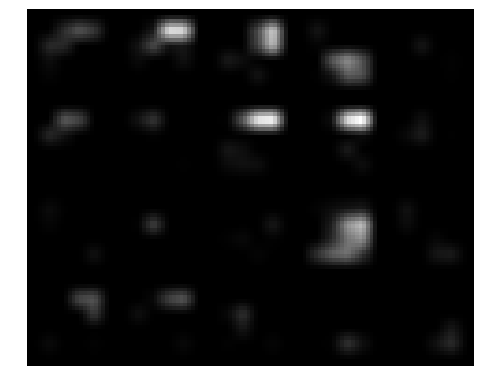

In [212]:
from skimage.transform import rescale
# plot of activation maps

plt.figure(figsize=(8,8))
n_row = 4
n_col = 5
p = 4 + 2
mosaic = np.zeros((p*n_row,p*n_col))
indx = 0
for i in range(n_row):
    for j in range(n_col):
        mosaic[i*p:(i+1)*p,j*p:(j+1)*p] = np.pad(D_[dict_indx][indx],(1,1),mode='constant')
        indx += 1

plt.imshow(rescale(mosaic,4,mode='constant'), cmap='gray')
plt.axis('off')
plt.show()        

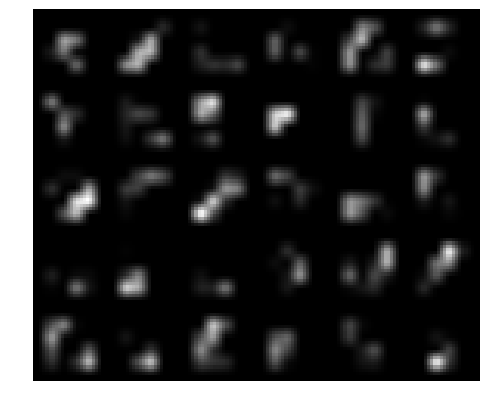

In [213]:
from skimage.transform import rescale
# plot of activation maps

plt.figure(figsize=(8,8))
n_row = 5
n_col = 6
p = 4 + 2
mosaic = np.zeros((p*n_row,p*n_col))
indx = 0
for i in range(n_row):
    for j in range(n_col):
        mosaic[i*p:(i+1)*p,j*p:(j+1)*p] = np.pad(D_[indx][channel_indx],(1,1),mode='constant')
        indx += 1

plt.imshow(rescale(mosaic,4,mode='constant'), cmap='gray')
plt.axis('off')
plt.show()        